# Code to calculate the layer thickness of tracers in 2x2 degree bins 


In [41]:
import cartopy
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.interpolate import interp2d
import matplotlib.patches as patches
import matplotlib as mpl

In [42]:
#import the data
df_final = pd.read_csv('csv_files/full_tracer_v15cold.csv')

# df2 = df_final.loc[((df_final['Landing Latitude'].between(-45, -30)) & (df_final['Depth'].between(10, 30)) & (df_final['Pressure'].between(0, 1.1e+10)))]

In [24]:
# new_df = df_final[df_final['Tracer Material'] == 4.0]

# land_longs = np.array(new_df['Landing Longitude'])
# land_lats = np.array(new_df['Landing Latitude'])
# volume = np.array(new_df['Volume'])
# depth = np.array(new_df["Depth"])
# pressure = np.array(new_df['Pressure']/10**9)
# trm = np.array(new_df['Tracer Material'])
# print(volume.sum())
# new_df

34000.0


Tracer Index  Ejection Time  Resultant Velocity  Launch Longitude  \
2                5     398.019287            1.188337        178.043452   
3                6     314.022797            0.679284        178.676098   
4                7     314.022797            0.679284        178.594896   
5                8     314.022797            0.679284        178.698046   
7               16     396.031891            0.847472        175.964830   
...            ...            ...                 ...               ...   
2062          8294     700.098389            0.033047        170.447973   
2070          8315     714.014771            0.131509        170.370088   
2212          8609     498.069611            0.605551        179.304912   
2223          8627     622.073975            0.158539        178.377987   
2235          8645     438.093414            0.651577        177.492296   

      Launch Latitude  Launch Angle      Height     Distance  \
2           63.326922     34.335207  287.041130  1627.917677   
3           64.981388     67.283759  158.803879   307.956582   
4           64.980646     67.284500  158.805465   307.947670   
5           64.981580     67.283563  158.803482   307.958969   
7           63.371086     46.926048  173.480814   731.114339   
...               ...           ...         ...          ...   
2062        59.904802    -27.174741    0.082905   292.831138   
2070        59.712500     -2.560253    0.012639  3355.739417   
2212        61.551200     35.740220   51.446961   486.486382   
2223        59.983251     15.329658    0.645123   556.604956   
2235        62.485700     46.112890   91.022887   477.842940   

      Landing Longitude  Landing Latitude  Tracer Material     Azimuth  \
2             -2.546014        -10.029844              4.0  179.276017   
3             -2.382468        -54.912340              4.0  176.522308   
4             -2.463628        -54.911890              4.0  176.522308   
5             -2.360564        -54.912455              4.0  176.522201   
7             -5.799700        -39.457260              4.0  176.640746   
...                 ...               ...              ...         ...   
2062         -23.799974        -54.204091              4.0  120.194704   
2070         -33.005424         48.493160              4.0  163.765146   
2212          -1.275238        -45.626985              4.0  178.521446   
2223          -4.131812        -41.825386              4.0  174.010494   
2235          -3.642394        -46.854077              4.0  177.121535   

           Depth      Pressure  Volume  
2     -73.086451  1.042551e+11   125.0  
3     -78.077004  1.010291e+11   125.0  
4     -83.067569  9.840282e+10   125.0  
5     -88.114873  9.544567e+10   125.0  
7     -78.090674  1.011635e+11   125.0  
...          ...           ...     ...  
2062 -142.791547  4.580482e+10   125.0  
2070 -137.892423  4.636316e+10   125.0  
2212 -152.472260  4.627011e+10   125.0  
2223 -152.485396  4.599094e+10   125.0  
2235 -152.511528  4.545327e+10   125.0  

[272 rows x 15 columns]

In [43]:
#convert to arrays
land_longs = np.array(df_final['Landing Longitude'])
land_lats = np.array(df_final['Landing Latitude'])
volume = np.array(df_final['Volume'])
depth = np.array(df_final["Depth"])
pressure = np.array(df_final['Pressure']/10**9)
trm = np.array(df_final['Tracer Material'])
velocity = np.array(df_final['Resultant Velocity'])
launch_angle = np.array(df_final['Launch Angle'])


#note that negative depths are above the surface, positive depths are below
# print(velocity.max())


In [44]:
#function to get layer thickness 
def binning(lats, longs, weights):
    final_latitude_bins = np.arange(-80, 81, 2)
    final_longitude_bins = np.arange(-180, 181, 2)

    H, _, _ = np.histogram2d(lats, longs, bins = (final_latitude_bins, final_longitude_bins), weights=weights)
    H_reflected, _, _ = np.histogram2d(lats, -longs, bins = (final_latitude_bins, final_longitude_bins), weights=weights)

    surface_area = abs(1750**2 * np.sin(np.deg2rad(90.5- final_latitude_bins[:-1])) *np.radians(1)* np.radians(1))
    surface_area = np.expand_dims(surface_area, axis=1)
    surface_area = np.repeat(surface_area, 180, axis=1) # make surface area same shape as H      
    layer_thickness = (H+H_reflected) / (surface_area)
    print(layer_thickness)
    return layer_thickness, final_latitude_bins, final_longitude_bins

    

In [45]:
def define_ellipse(lat, lon, a, b, rot):
    '''
    Find the coordinates of the edge of an ellipse,
    given the central point, semimajor and semiminor 
    axes and the rotation

    Inputs
    ------
    lat: float
        Central latitude, in degrees
    lon: float
        Central longitude, in degrees
    a: float
        semimajor axes length, in km
    b: float
        semiminor axes length, in km
    rot: float
        angle of rotation of semi-major axes from N-S, in degrees

    Returns
    -------
    ndarray
        Final latitudes, in degrees
    ndarray
        Final longitudes, in degrees
    '''

    # Range of angles to calculate ellipse for
    ang_r = np.radians(np.arange(0, 361, 1))

    # Unrotated ellipse coords
    xs = b * np.cos(ang_r)
    ys = a * np.sin(ang_r)

    # Rotate by desired amount
    rot_r = np.radians(rot)
    xr = xs * np.cos(rot_r) + ys * np.sin(rot_r)
    yr = -xs * np.sin(rot_r) + ys * np.cos(rot_r)

    # Calculate distance and bearing to each point from centre
    dist = np.sqrt(xr**2 + yr**2) / 1750
    brng = np.arctan2(xr, yr)
    brng[xr < 0] += 2 * np.pi

    # Convert central lat/lon to radians
    rlat = np.radians(np.asarray(lat))
    rlon = np.radians(np.asarray(lon))

    # Find final lats and lons for each point on ellipse, using bearing and distance
    final_lat = np.arcsin(np.sin(rlat)*np.cos(dist)
                          + (np.cos(brng)*np.cos(rlat))*np.sin(dist))
    final_lon = (rlon + np.arctan2(np.sin(brng)*np.cos(rlat)*np.sin(dist),
                                   np.cos(dist)-np.sin(rlat)*np.sin(final_lat)))


    return np.degrees(final_lat), np.degrees(final_lon)

## plot layer thickness for all tracers in the data frame:

In [5]:

# layer_thickness = binning(land_lats, land_longs, volume)
# fig, ax = plt.subplots(figsize=(13, 4))
# # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
# final_plot = ax.imshow(np.log10(layer_thickness), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80], cmap = 'magma')
# plt.xlabel('longs')
# plt.ylabel('lats')
# ax.grid()

# cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
# # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
# # cbar.minorticks_on()
# plt.savefig('thickness.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')

## Makes separate layer thickness plots filtered by each depth range:

In [16]:
# depth_min = 0
# depth_max = 180
# bin_size = 20

# for min_range in np.arange(depth_min, depth_max, bin_size):
#     max_range = min_range + bin_size 
#     min_filter = depth > min_range
#     max_filter = depth < max_range
#     range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
#     filtered_lats = land_lats[range_filter]
#     filtered_longs = land_longs[range_filter]
#     filtered_volume = volume[range_filter]
#     filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
#     filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
    
#     fig, ax = plt.subplots(figsize=(13, 4))
#     # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
#     final_plot = ax.imshow((filtered_layer_thickness_log), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80])
#     plt.xlabel('longs')
#     plt.ylabel('lats')
#     ax.grid()

#     cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
#     # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
#     # cbar.minorticks_on()
#     plt.savefig(f'Figures/v15/depth_bins/filtered_thickness_({min_range},{max_range}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    

## Makes separate layer thickness plots filtered by pressure range:

In [15]:
# pressure_mins = [0, 5, 10, 25, 50, 100]

# pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]

# pressure_tuple = list(zip(pressure_mins,pressure_maxs))

# for min_range, max_range in pressure_tuple:
#     min_filter = pressure > min_range
#     max_filter = pressure < max_range
#     range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
#     filtered_lats = land_lats[range_filter]
#     filtered_longs = land_longs[range_filter]
#     filtered_volume = volume[range_filter]
#     filtered_layer_thickness = binning(filtered_lats, filtered_longs, filtered_volume)
    
#     fig, ax = plt.subplots(figsize=(13, 4))
#     # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
#     final_plot = ax.imshow(np.log10(filtered_layer_thickness), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80], cmap = 'magma')
#     plt.xlabel('longs')
#     plt.ylabel('lats')
#     ax.grid()

#     cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
#     # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
#     # cbar.minorticks_on()
#     plt.savefig(f'Figures/v15/pressure_bins/filtered_thickness_({min_range},{np.round(max_range)}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    

In [27]:
def cartopy_plot():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    fig = plt.figure(figsize=[14, 14])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
    ax1.set_global()
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])
    Z = np.log10(layer_thickness)
    print(layer_thickness.min())
    print(layer_thickness.max())
    print(np.mean(layer_thickness))
    lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)   #inner ellipse
    lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0) #outer ellipse
    lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0)   #transient crater
    plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=1, cmap ='tab10')


    cbar = fig.colorbar(plot, label='Log10 Ejecta Thickness', location = 'bottom',shrink = 0.8, pad = 0.02)

    ax1.gridlines(draw_labels = True)
    ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2, label = 'Outer Ellipse')
    ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label ='Inner Ellipse')
    ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2, label = 'Transient Crater Rim')
    ax1.plot(122, 11, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =2, label = 'Reiner Gamma')
    ax1.plot(-157, 14, marker = 'x',c ='blue',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =2, label = 'Descartes')
    
        
                
    ax1.legend(bbox_to_anchor=(0.75, 0.5, 0.3, 0.5))
    
#     plt.savefig(f'Figures/layer_thickness_impactor_core_v15.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')






   
    

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
2.6412730413035517
0.007775459665087797


/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/568007311.py:23: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(layer_thickness)


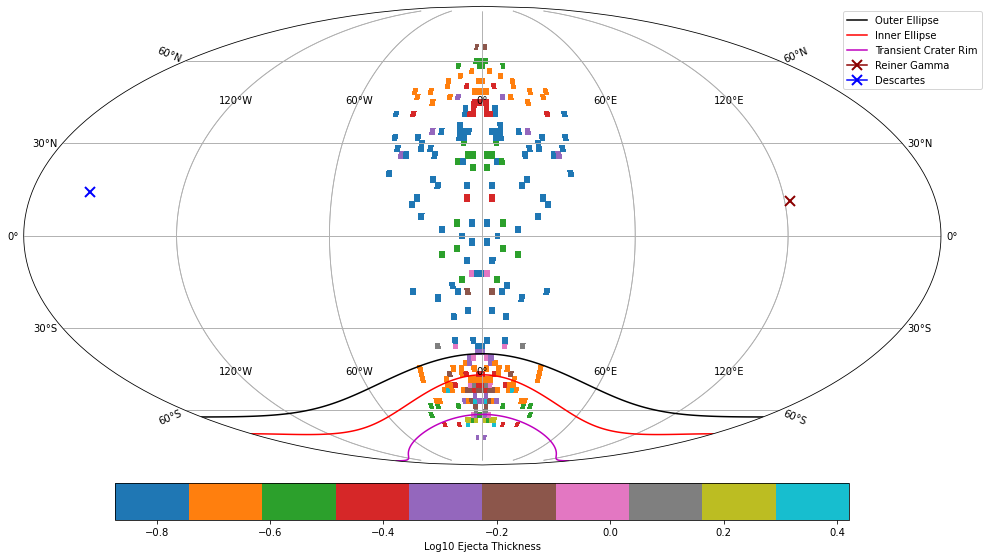

In [28]:
cartopy_plot()

In [33]:

def cartopy_plot_depth():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    depth_min = -180
    depth_max = -30
    bin_size = 50
    for min_range in np.arange(depth_min, depth_max, bin_size):
        
        max_range = min_range + bin_size 
        min_filter = depth > min_range
        max_filter = depth < max_range
        range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
        filtered_lats = land_lats[range_filter]
        filtered_longs = land_longs[range_filter]
        filtered_volume = volume[range_filter]
        filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
        filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

    
        fig = plt.figure(figsize=[14, 14])
        plt.tight_layout()
        ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
        fig.subplots_adjust(bottom=0.05, top=0.95,
                            left=0.04, right=0.95, wspace=0.02)

        # Limit the map to -60 degrees latitude and below.
        ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
        ax1.set_global()
        ax1.gridlines()

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])
        
        Z = np.log10(filtered_layer_thickness)
        plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=3)

        


        cbar = fig.colorbar(plot, label='log10 Thickness (km)', location = 'bottom',shrink = 0.8, pad = 0.02)




        ax1.gridlines(draw_labels = True)
#         plt.show()
        plt.savefig(f'Figures/filtered_thickness_({min_range},{max_range}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


    
 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_36190/3948762527.py:16: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_36190/3948762527.py:40: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(filtered_layer_thickness)


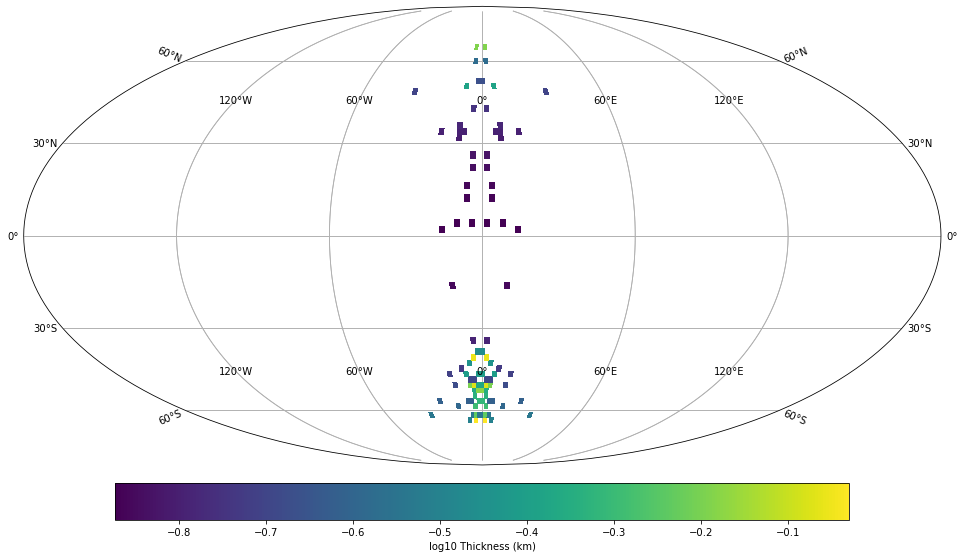

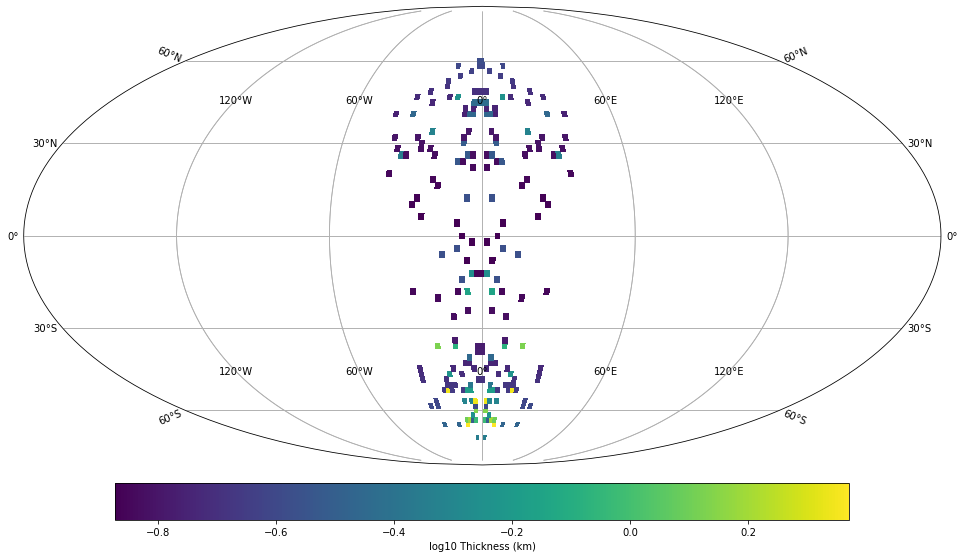

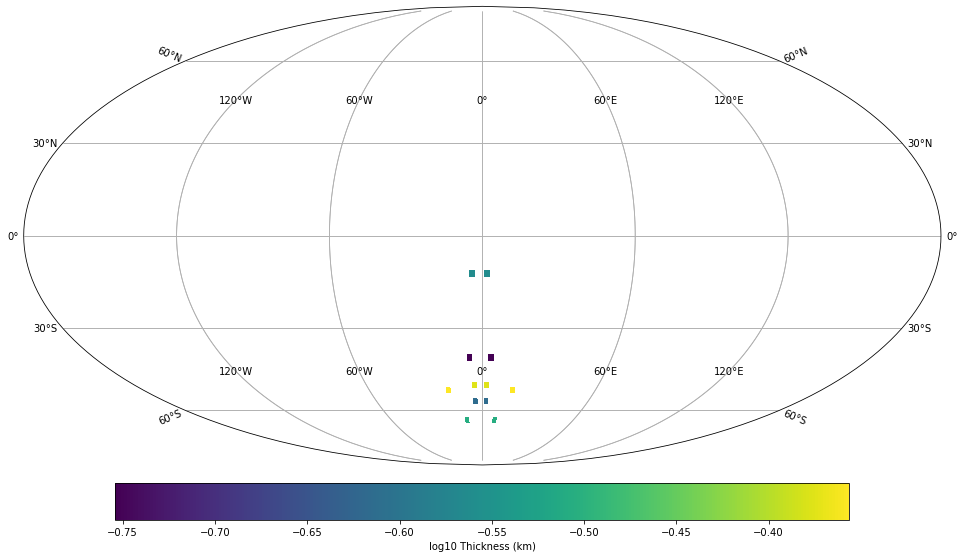

In [34]:
cartopy_plot_depth()

In [31]:
def cartopy_plot_pressure():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 5, 10, 25, 50, 100]

    pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]

    pressure_tuple = list(zip(pressure_mins,pressure_maxs))
    
    for min_range, max_range in pressure_tuple:
        min_filter = pressure > min_range
        max_filter = pressure < max_range
        range_filter = min_filter & max_filter 
        filtered_lats = land_lats[range_filter]
        filtered_longs = land_longs[range_filter]
        filtered_volume = volume[range_filter]
        filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
        filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

        fig = plt.figure(figsize=[14, 14])
        plt.tight_layout()
        ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
        fig.subplots_adjust(bottom=0.05, top=0.95,
                            left=0.04, right=0.95, wspace=0.02)

        # Limit the map to -60 degrees latitude and below.
        ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
        ax1.set_global()
        ax1.gridlines()

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

        Z = np.log10(filtered_layer_thickness)
        lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
        lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
        lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0)
        plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=3, cmap = 'magma')
        ax1.gridlines(draw_labels = True)
        ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2, label = 'Outer Ellipse')
        ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label ='Inner Ellipse')
        ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2, label = 'Transient Crater Rim')
        ax1.plot(-143, 12.97, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =3, label = 'Troctolite Sample')
                
        
                
        ax1.legend(bbox_to_anchor=(0.75, 0.5, 0.3, 0.5))
    
   






        cbar = fig.colorbar(plot, label='Log10 Ejecta Thickness', location = 'bottom',shrink = 0.8, pad = 0.02)

    
    
        plt.savefig(f'Figures/filtered_thickness_({min_range},{np.round(max_range)}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    
    

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:17: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:40: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(filtered_layer_thickness)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:17: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:40: RuntimeWarning: divide by zero encountered in l

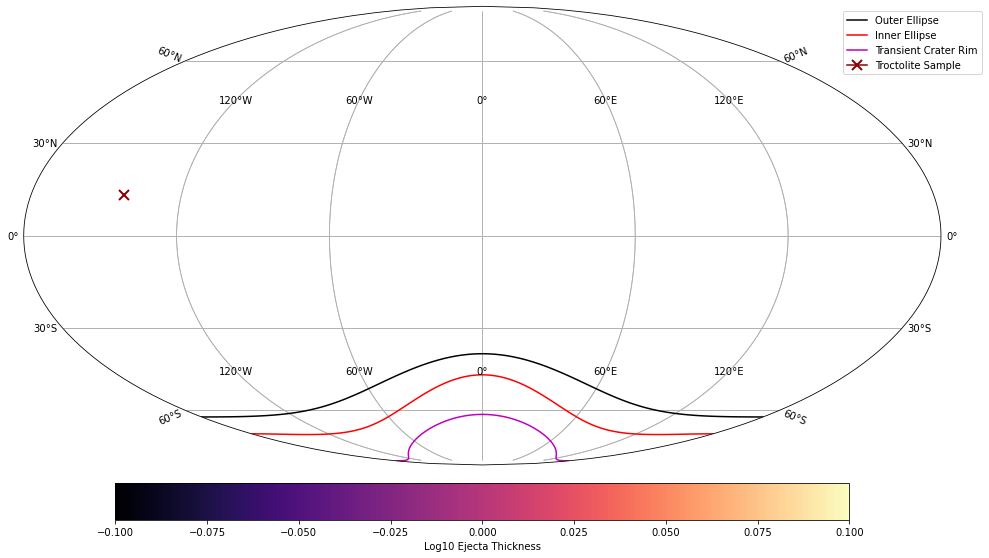

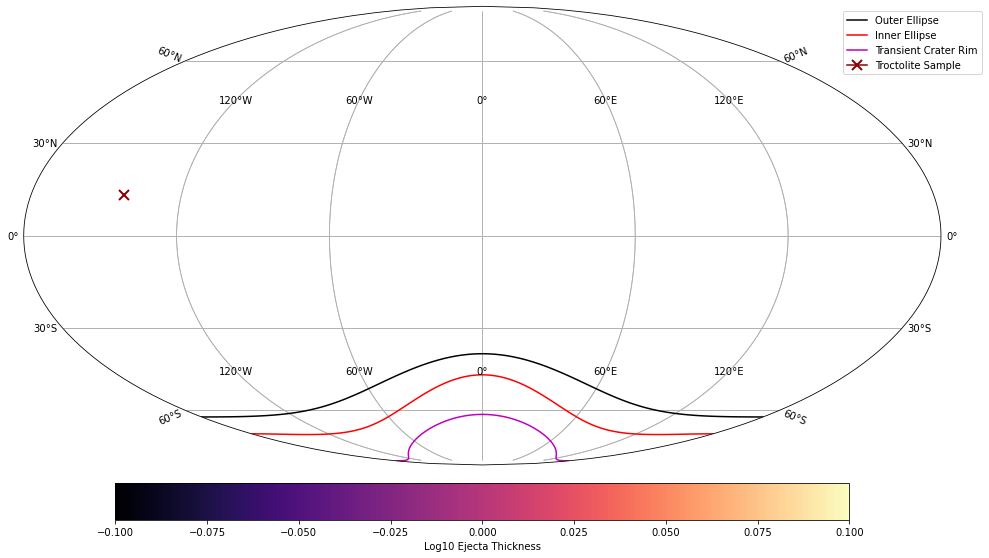

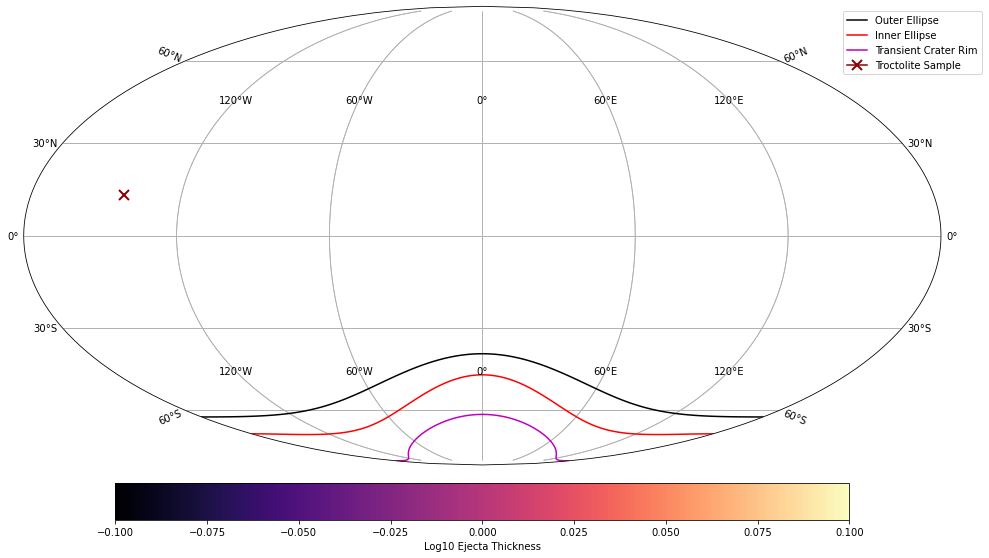

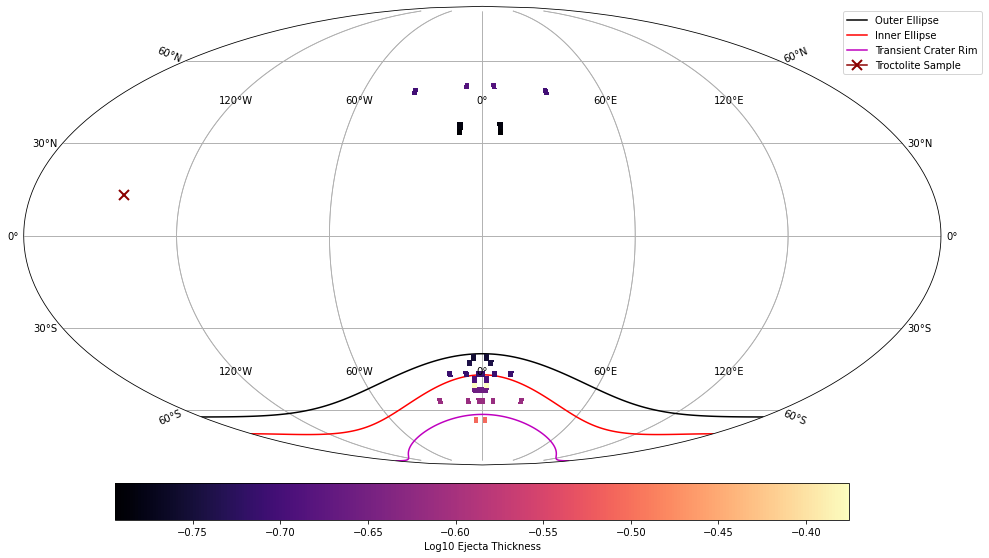

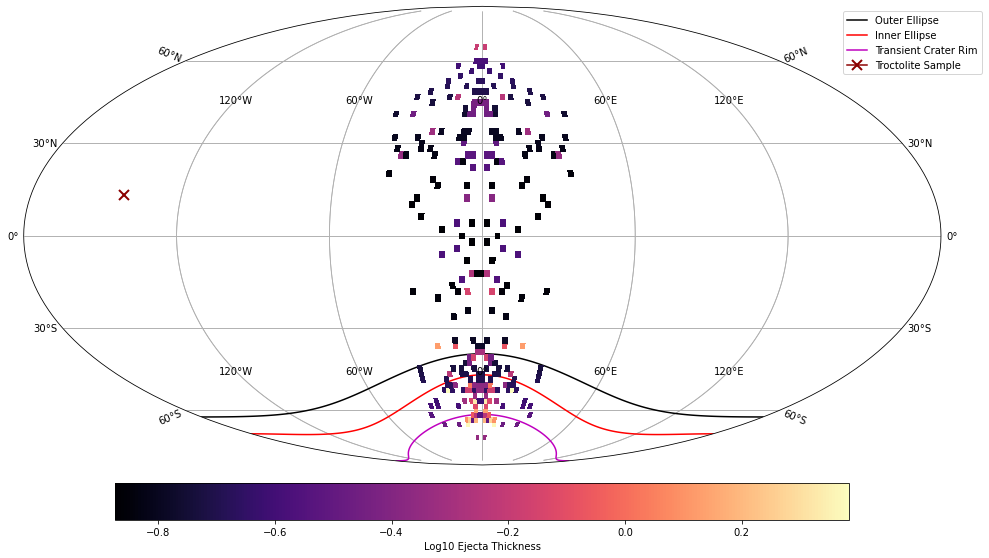

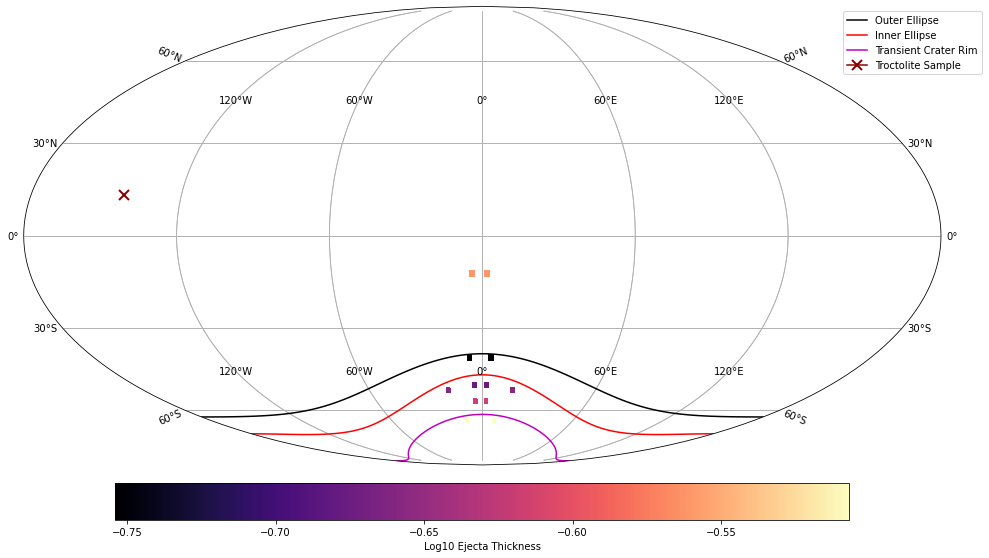

In [32]:
cartopy_plot_pressure()

In [46]:
def thickness_masking(mask):
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    filtered_lats = land_lats[mask]
    filtered_longs = land_longs[mask]
    filtered_volume = volume[mask]
    filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
    filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

    return filtered_layer_thickness





In [7]:
def cartopy_plot_nested():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 6, 10, 25, 50, 100]
    pressure_maxs = [6, 10, 25, 50, 100, pressure.max()]
    pressure_tuple = list(zip(pressure_mins,pressure_maxs))

    depth_min = 10
    depth_max = 180
    bin_size = 20
    for min_p, max_p in pressure_tuple:
        for min_range in np.arange(depth_min, depth_max, bin_size):
            max_range = min_range + bin_size
            min_filter = depth > min_range
            max_filter = depth < max_range
            depth_filter = min_filter & max_filter
            
            min_filt = pressure > min_p
            max_filt = pressure < max_p
            pressure_filter = min_filt & max_filt
            
    
            final_mask= pressure_filter*depth_filter
            if np.any(np.isin(final_mask, True)) == True:
                layer_thickness_pressure = thickness_masking(pressure_filter)
                layer_thickness_depth = thickness_masking(depth_filter)
                layer_thickness_combined = thickness_masking(final_mask)
            

                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_pressure)
                Z2 = np.log10(layer_thickness_depth)
                Z3 = np.log10(layer_thickness_combined)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
                lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0) #transient crater
                
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin = -1, vmax = 2)
                cbar1 = plt.colorbar(plot1, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                ax1.set_title(f'Pressure Filter: {min_p} to {np.round(max_p)} Gpa')
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin = -1, vmax = 2)
                cbar2 = plt.colorbar(plot2, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                ax2.set_title(f'Depth Filter: {min_range} to {np.round(max_range)} km')
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin = -1, vmax = 2)
                cbar3 = plt.colorbar(plot1, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax3.set_title('Combined Filter:')
                #plotting the outer ellipse topography
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2,label = 'Outer Ellipse')
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                
                #plotting the inner ellipse topography
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label = 'Inner Ellipse')
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
              
                #plotting the transient crater
                ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2,label = 'Transient Crater Rim')
                ax2.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                #plotting the troctolite sample
                ax1.plot(-139, 45, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =3, label = 'Troctolite Sample')
                ax2.plot(-139, 45,marker = 'x', c='darkred',ms=10,mew= 2,transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(-139, 45,marker = 'x', c='darkred',ms=10,mew= 2,transform=ccrs.Geodetic(), zorder =2)
                ax1.legend(loc = 'upper right', bbox_to_anchor=(0.8, 0.7, 0.3, 0.5))
                
                
                
            
                
                
                plt.savefig(f'Figures/cold_profile/filtered_thickness__depth({min_range},{np.round(max_range)}),_pressure({min_p},{max_p}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')






[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.   

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[ 0.          8.72763295  0.         ...  0.          8.72763295
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [17.41985709  0.          5.78405009 ...  5.78405009  0.
  17.41985709]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[ 0.          8.72763295  0.         ...  0.          8.72763295
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [17.41985709  0.          5.78405009 ...  5.78405009  0.
  17.41985709]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[23.74904828 47.88205438 23.65585318 ... 23.65585318 47.88205438
  23.74904828]
 [ 0.         13.31229815 39.46351725 ... 39.46351725 13.31229815
   0.        ]
 [33.46032848 16.26964629 16.74391691 ... 16.74391691 16.26964629
  33.46032848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[23.74904828 47.88205438 23.65585318 ... 23.65585318 47.88205438
  23.74904828]
 [ 0.         13.31229815 39.46351725 ... 39.46351725 13.31229815
   0.        ]
 [33.46032848 16.26964629 16.74391691 ... 16.74391691 16.26964629
  33.46032848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[23.74904828 47.88205438 23.65585318 ... 23.65585318 47.88205438
  23.74904828]
 [ 0.         13.31229815 39.46351725 ... 39.46351725 13.31229815
   0.        ]
 [33.46032848 16.26964629 16.74391691 ... 16.74391691 16.26964629
  33.46032848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[23.74904828 47.88205438 23.65585318 ... 23.65585318 47.88205438
  23.74904828]
 [ 0.         13.31229815 39.46351725 ... 39.46351725 13.31229815
   0.        ]
 [33.46032848 16.26964629 16.74391691 ... 16.74391691 16.26964629
  33.46032848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[23.74904828 47.88205438 23.65585318 ... 23.65585318 47.88205438
  23.74904828]
 [ 0.         13.31229815 39.46351725 ... 39.46351725 13.31229815
   0.        ]
 [33.46032848 16.26964629 16.74391691 ... 16.74391691 16.26964629
  33.46032848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[14.53515186 14.62159604  0.         ...  0.         14.62159604
  14.53515186]
 [ 5.64088867 17.45512083 30.45694508 ... 30.45694508 17.45512083
   5.64088867]
 [ 9.69196288  9.72067649  0.         ...  0.          9.72067649
   9.69196288]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.78500499 ...  1.78500499  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 71.9840494  105.37902454 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[6.81407648 6.81426589 0.         ... 0.         6.81426589 6.81407648]
 [0.         5.6743429  5.70804065 ... 5.70804065 5.6743429  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.655

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=[14, 14])
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel

[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.     

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/3407490203.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)


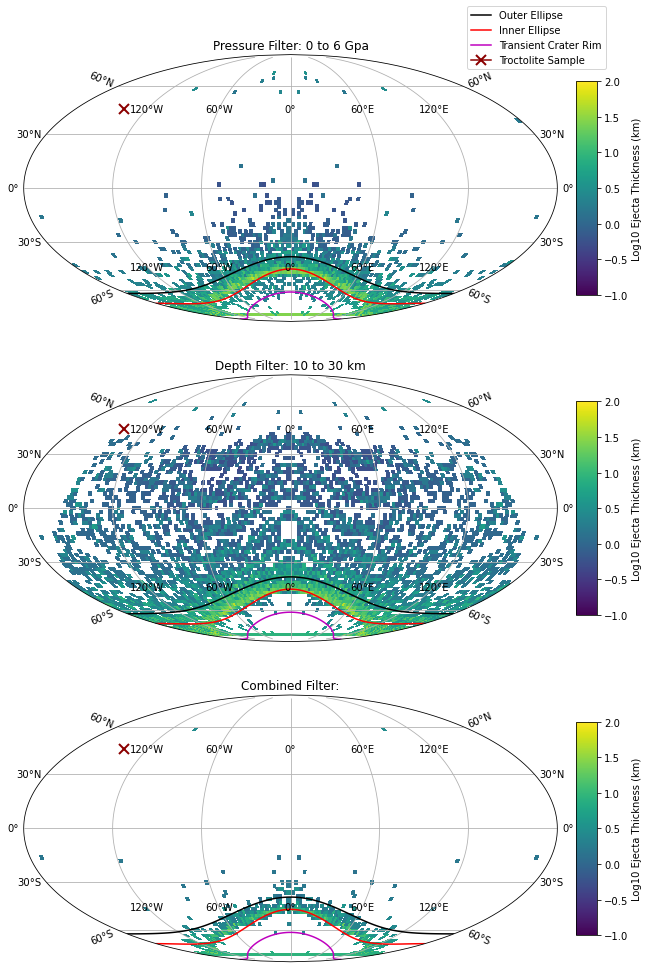

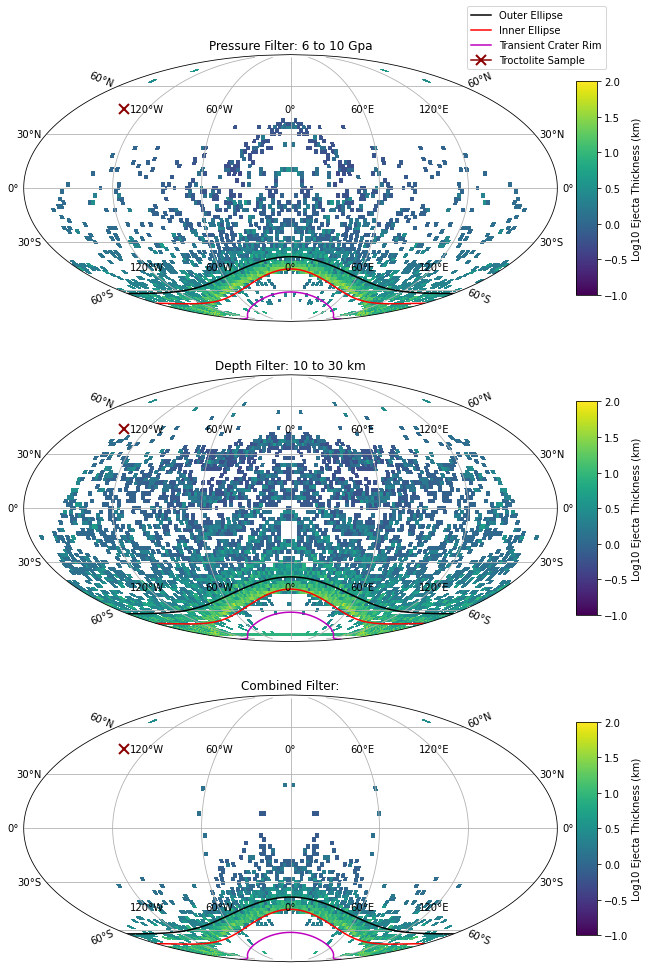

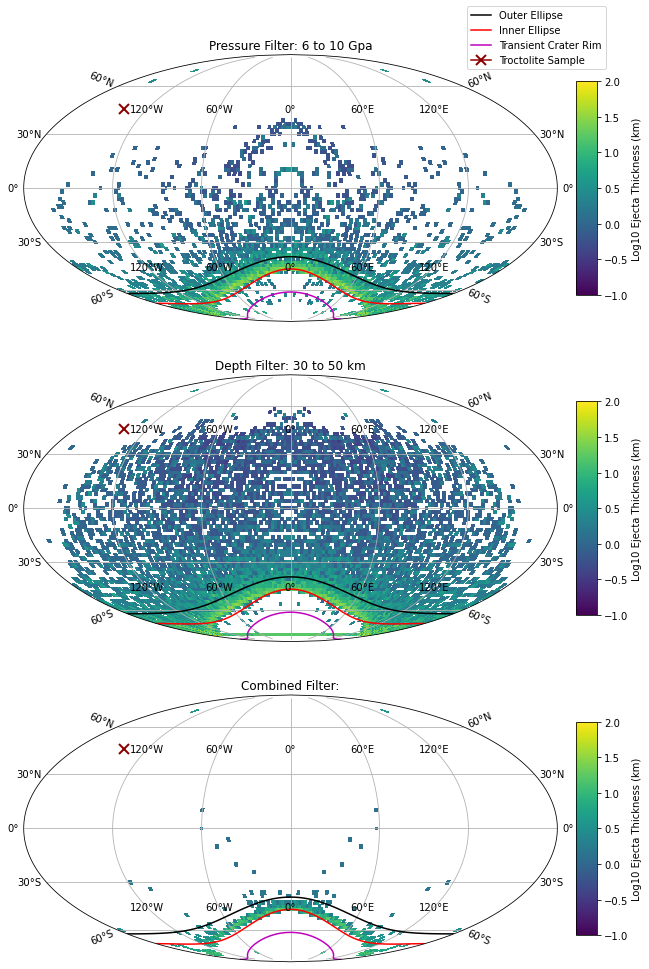

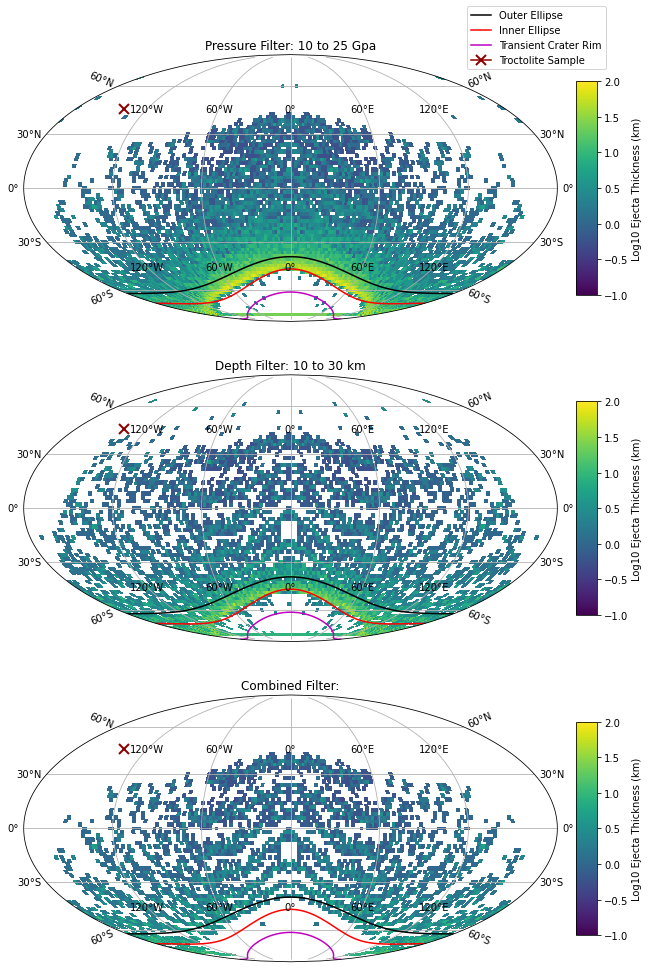

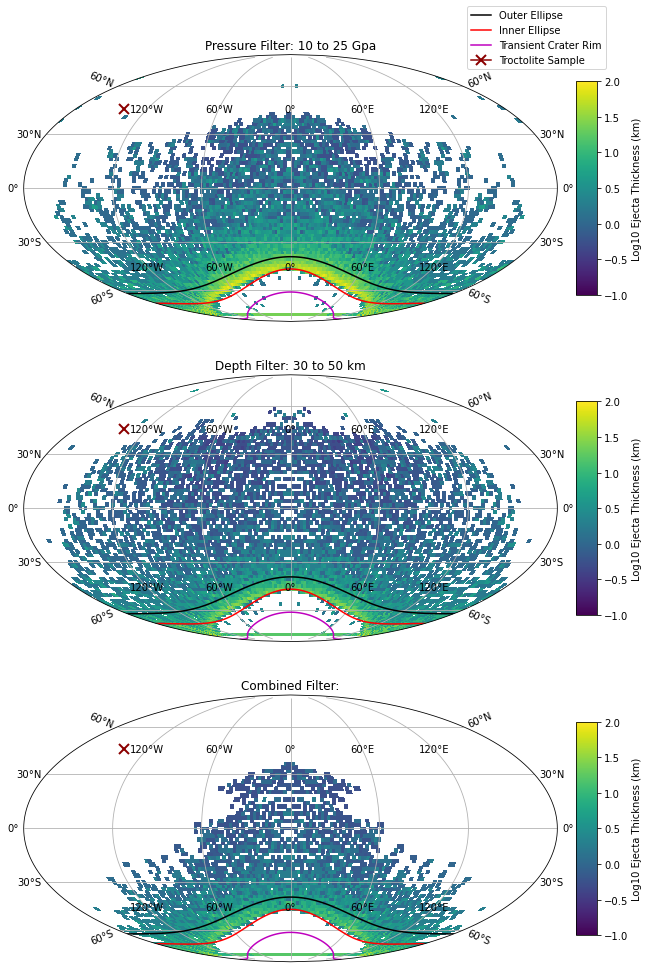

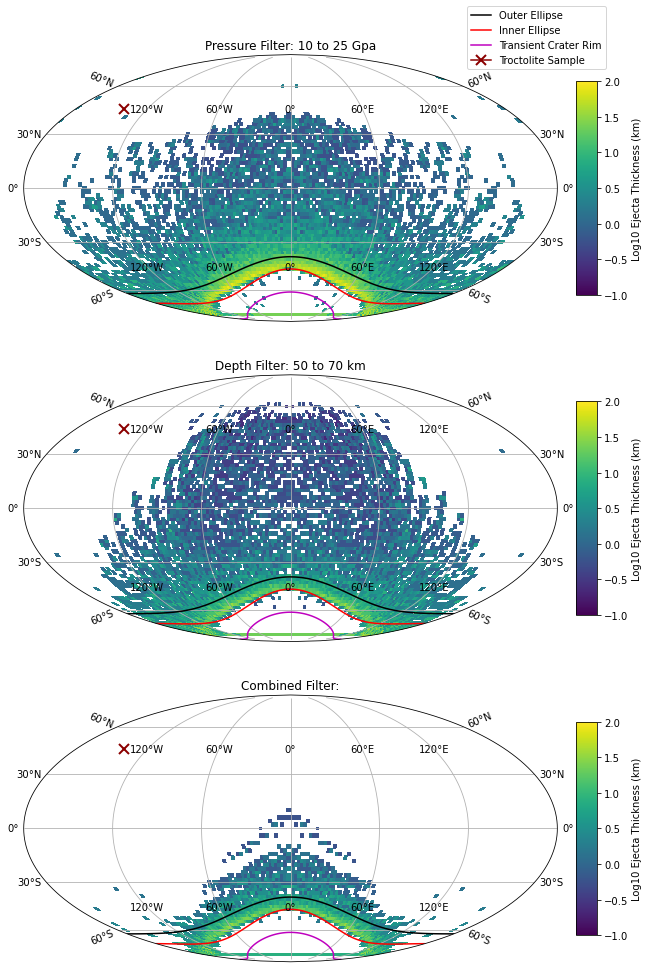

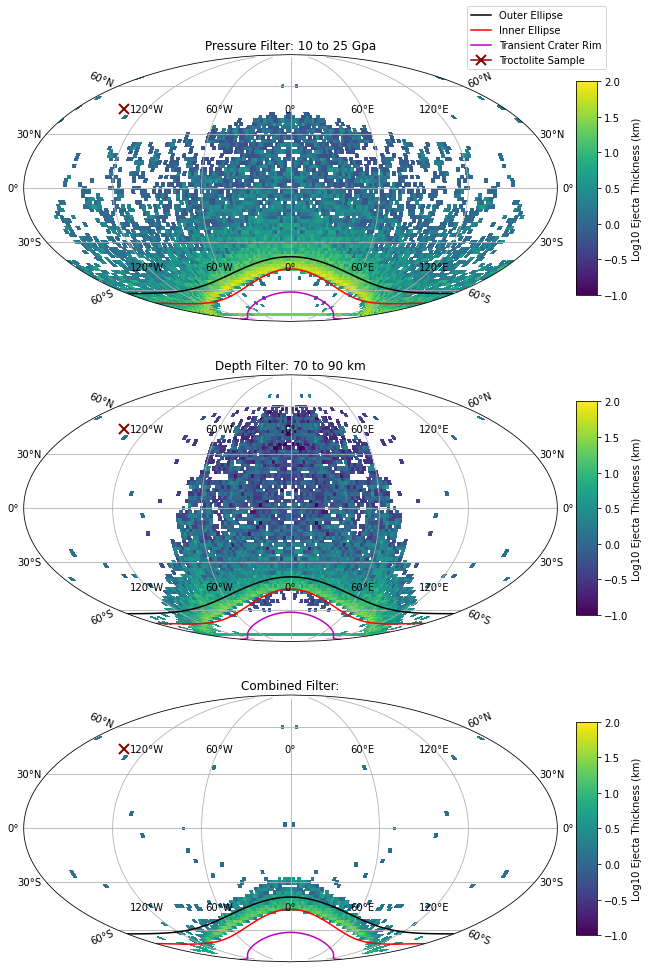

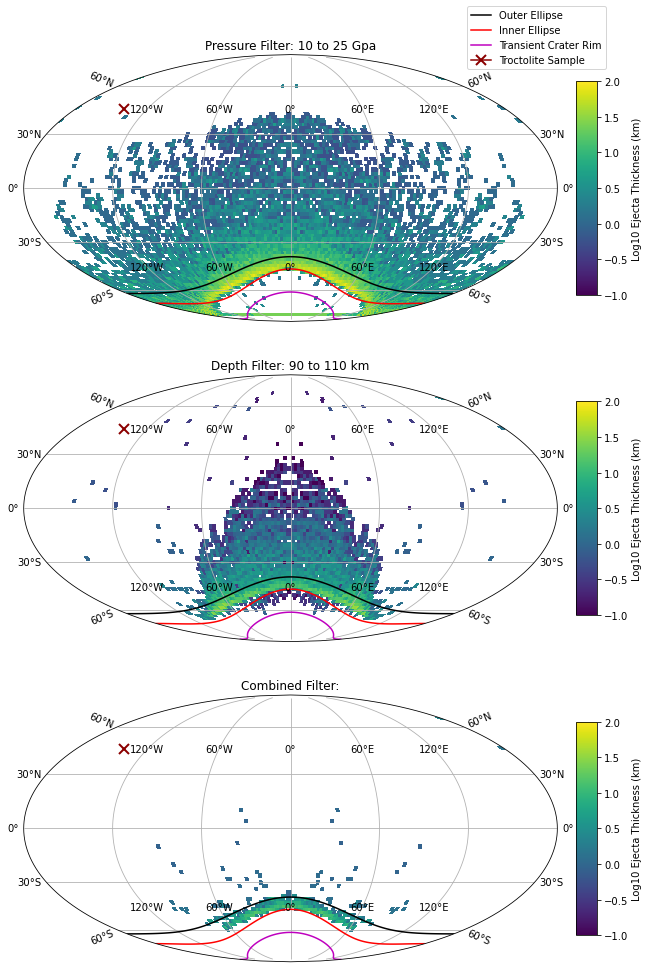

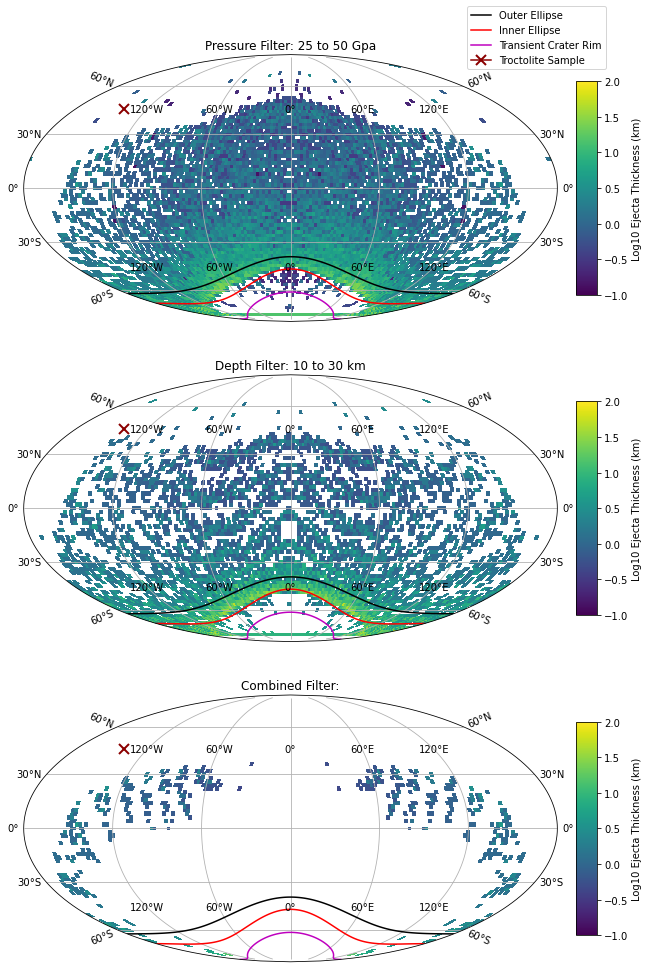

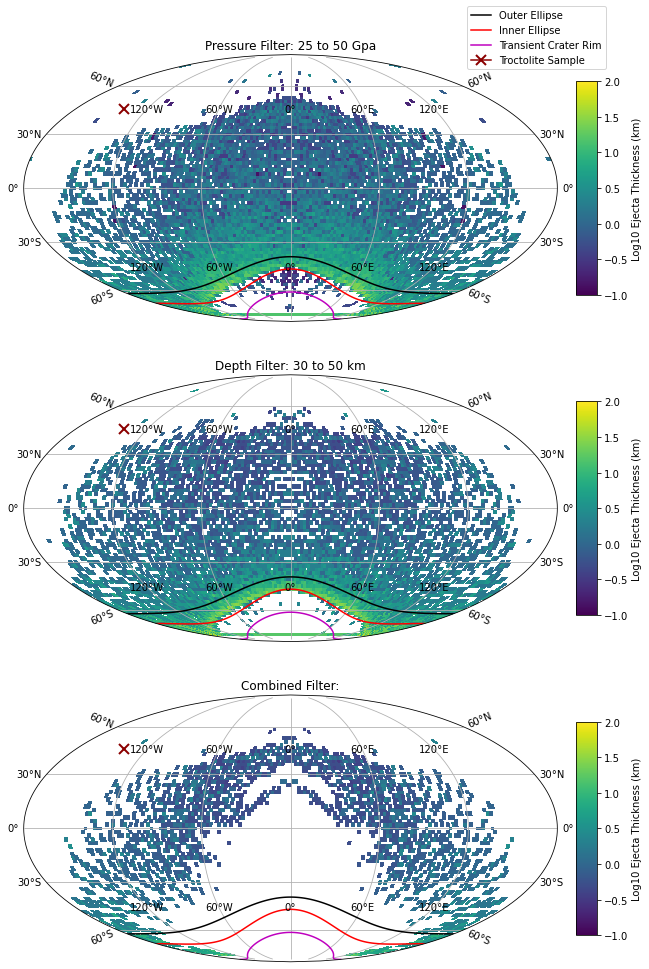

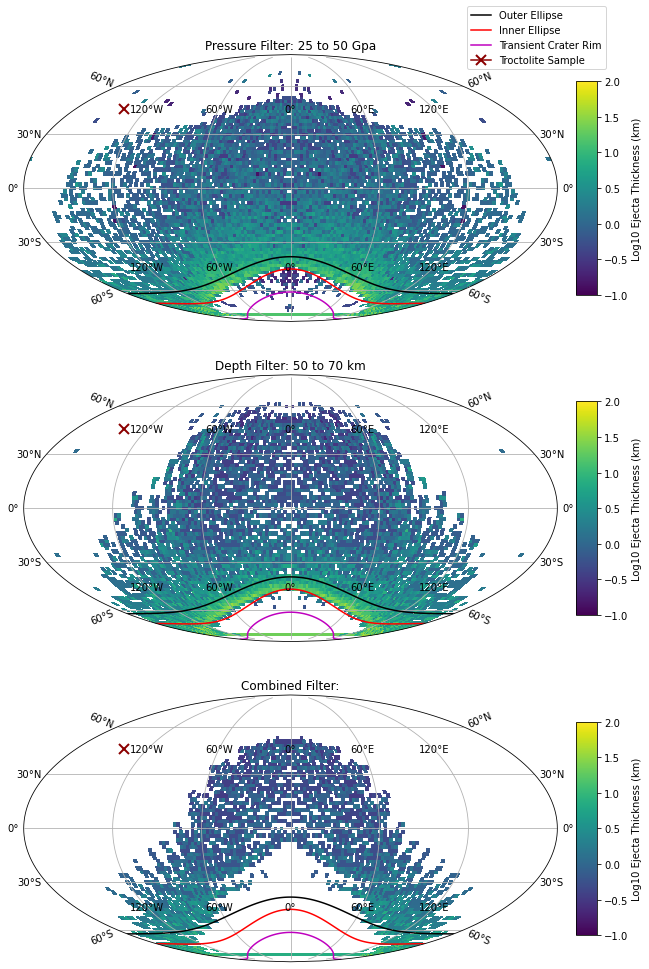

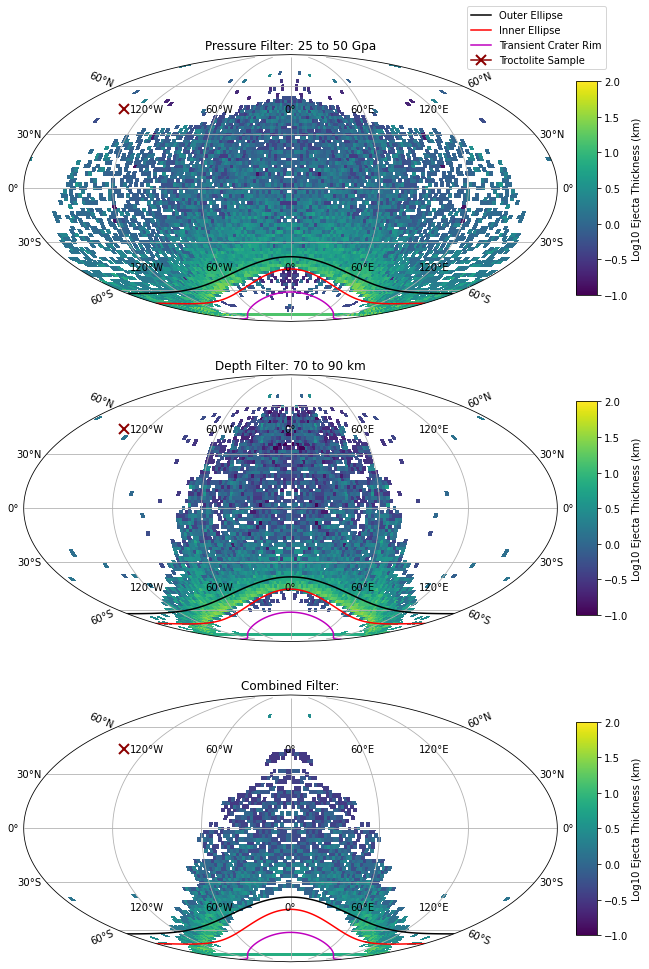

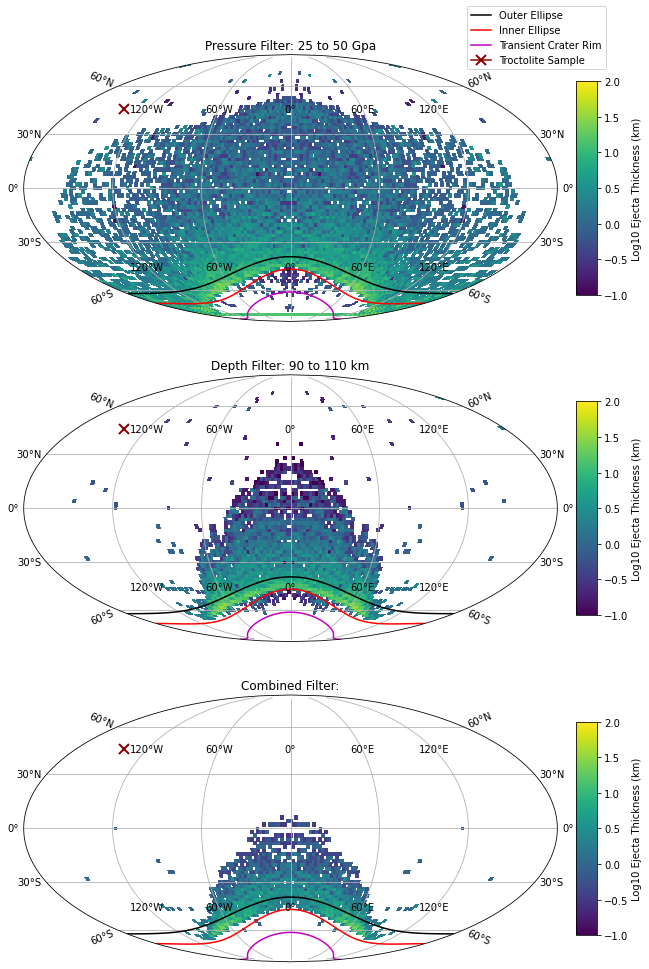

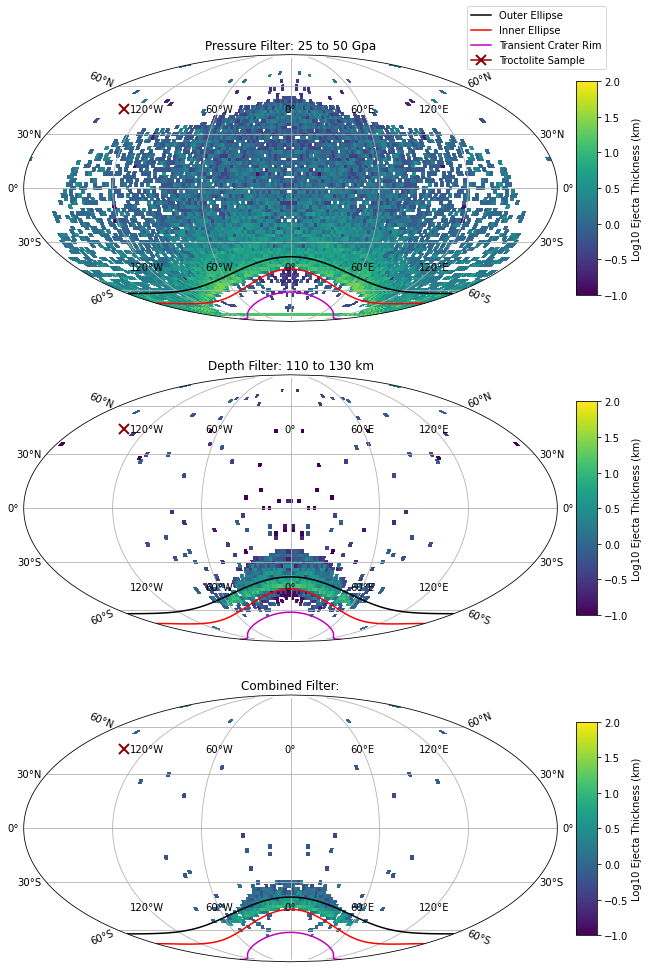

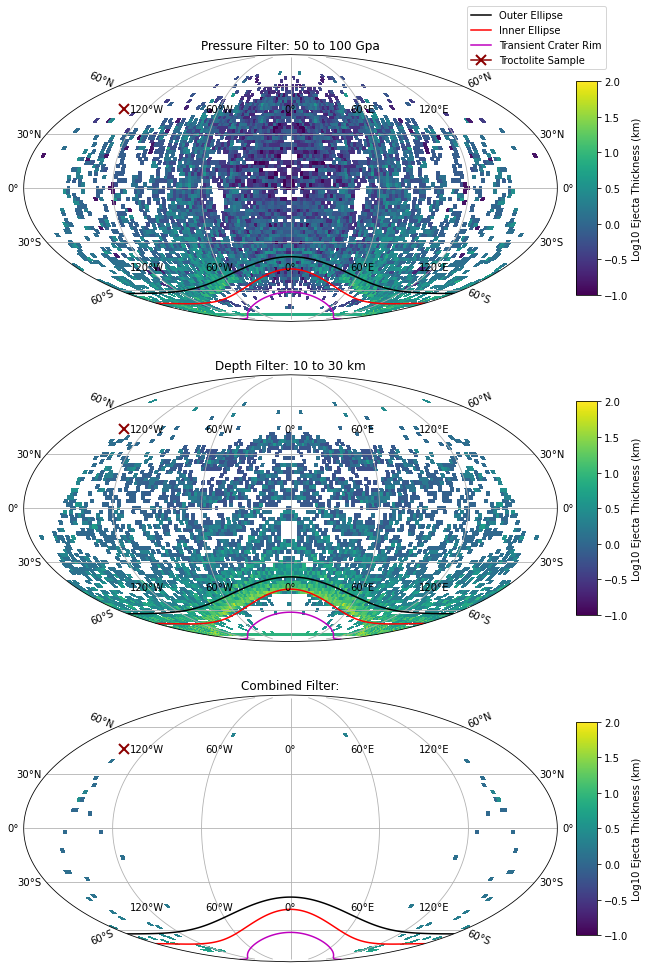

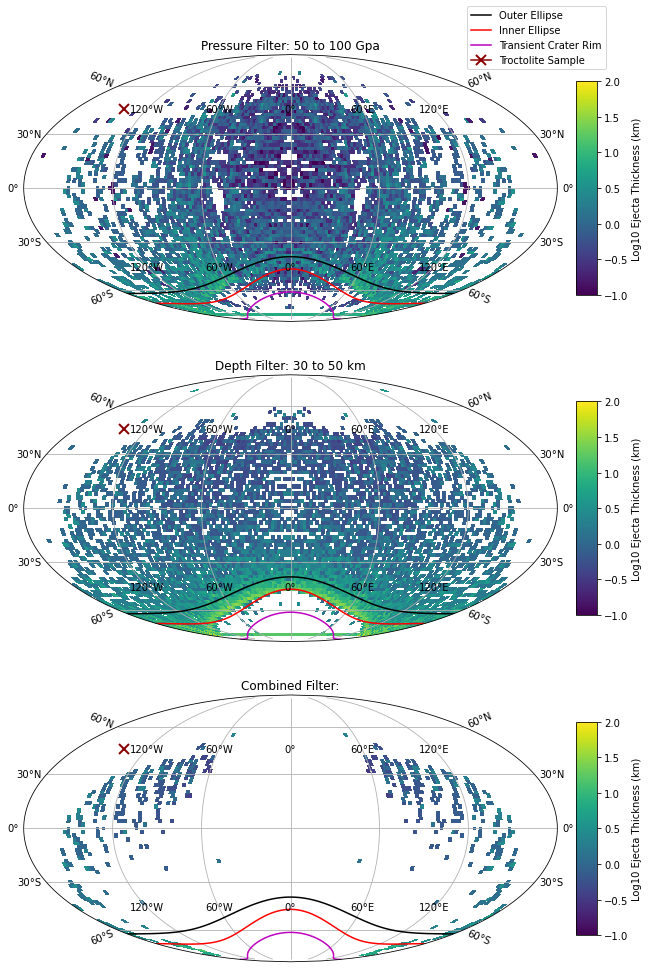

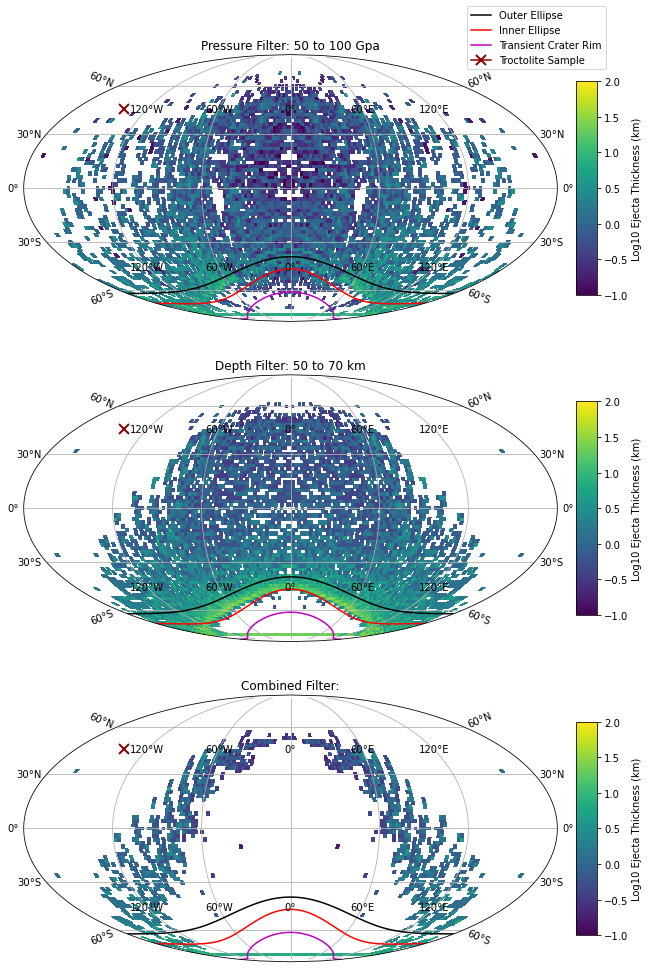

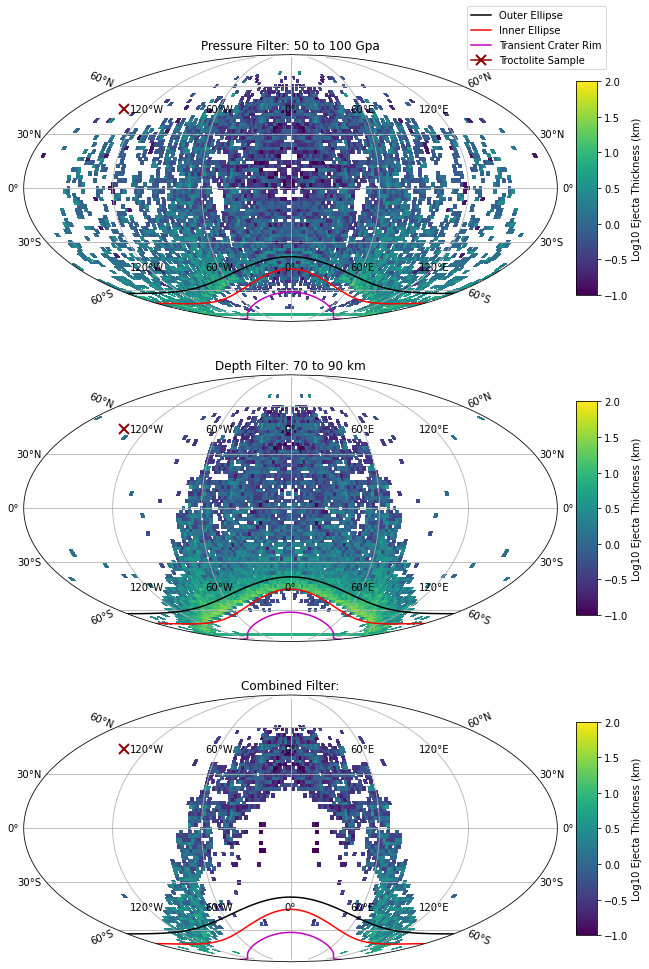

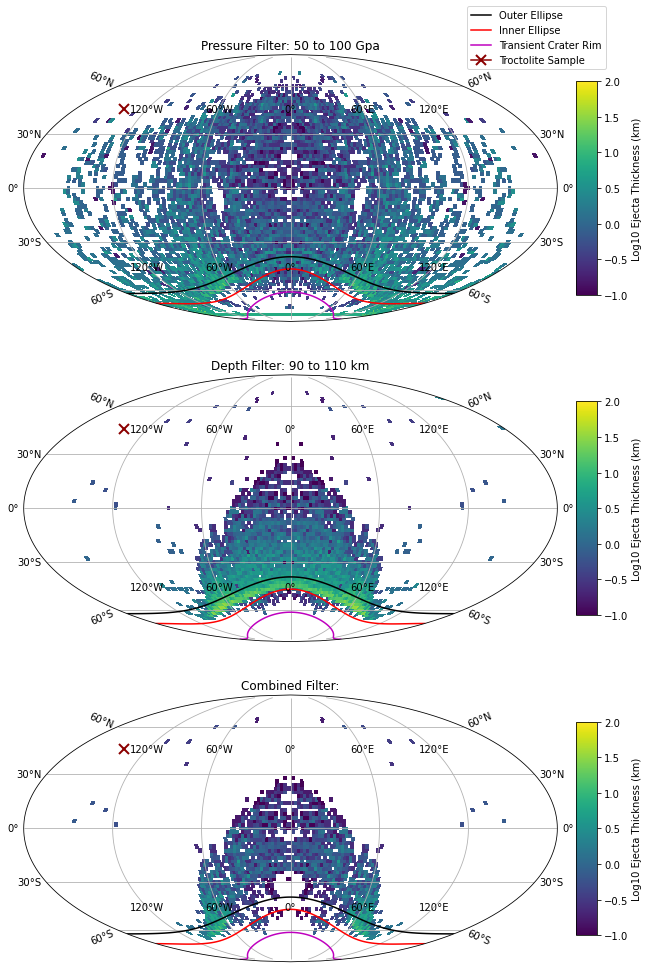

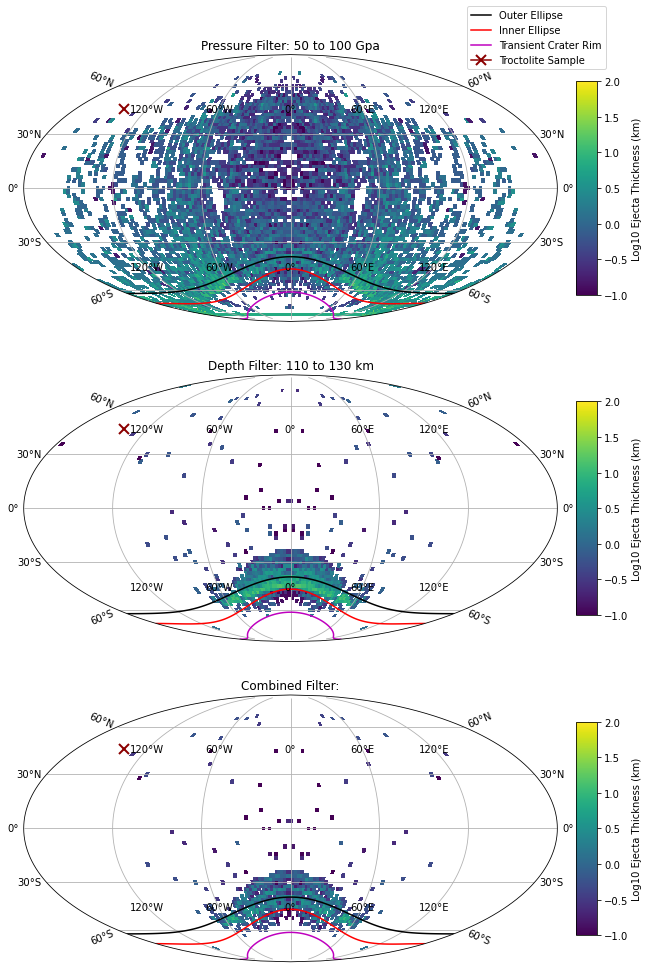

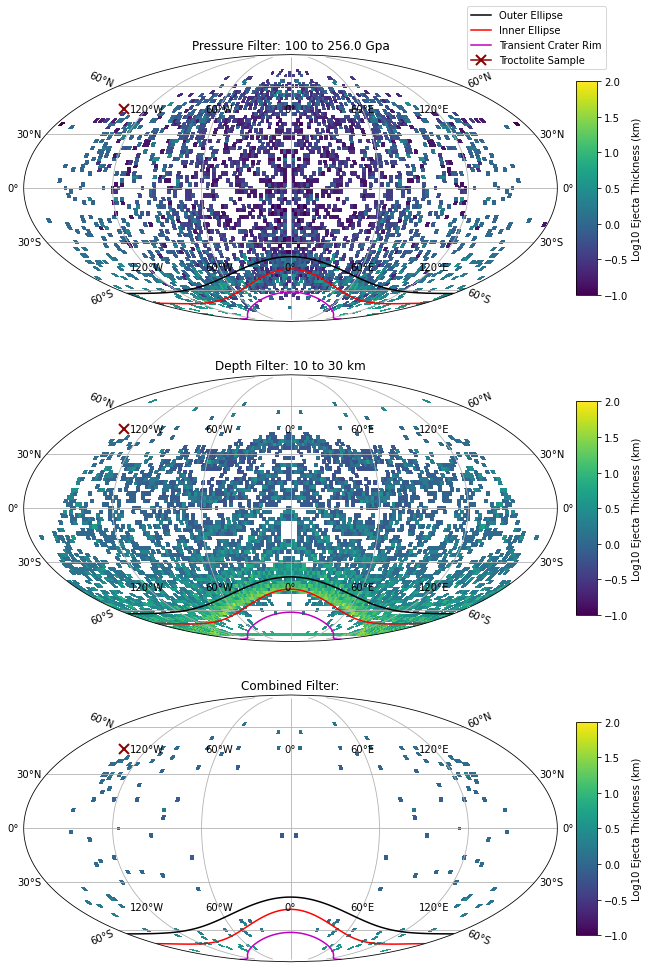

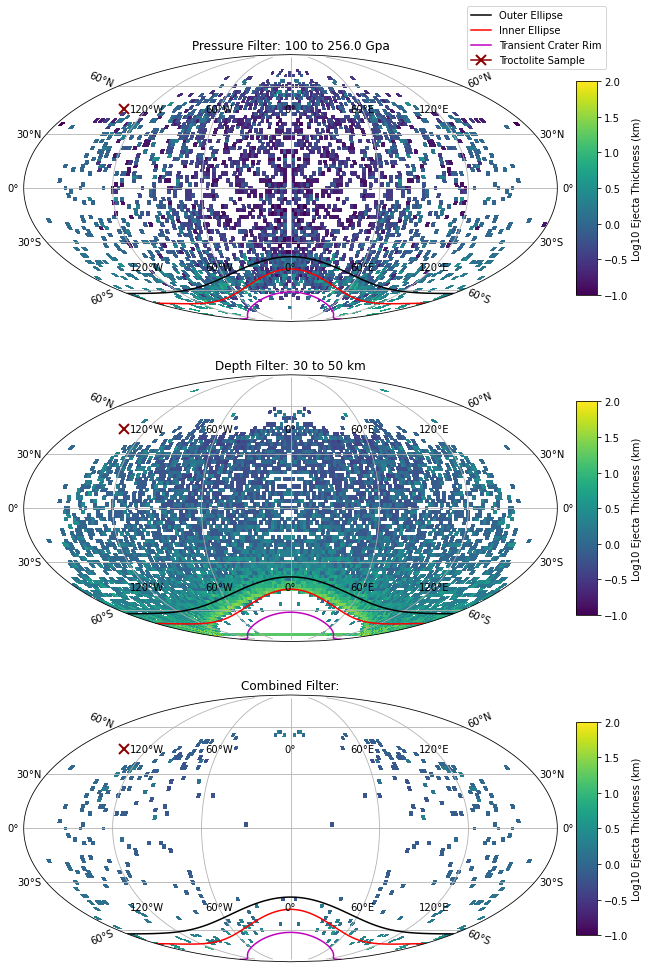

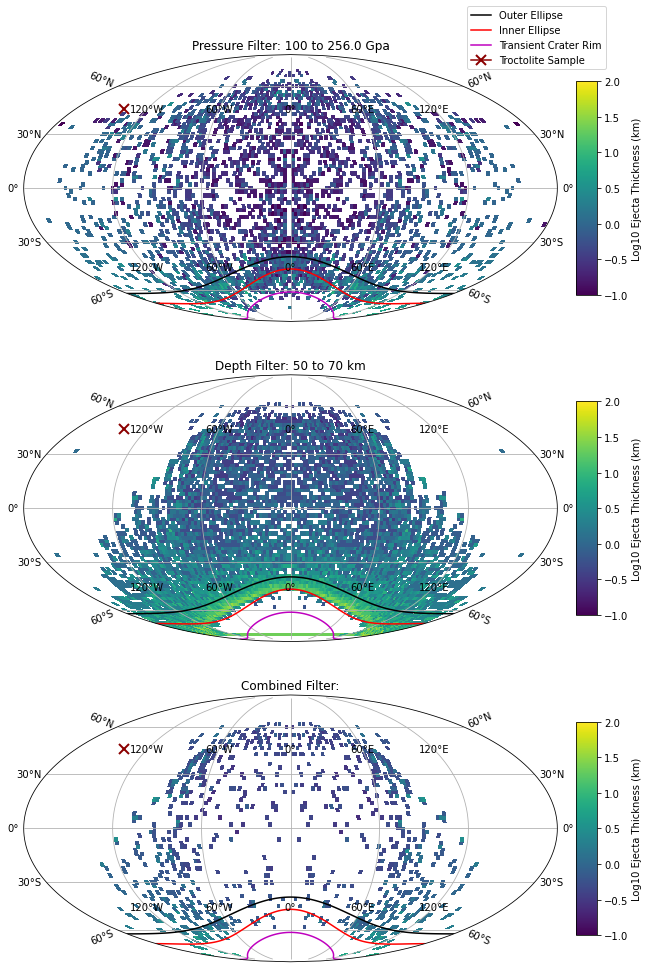

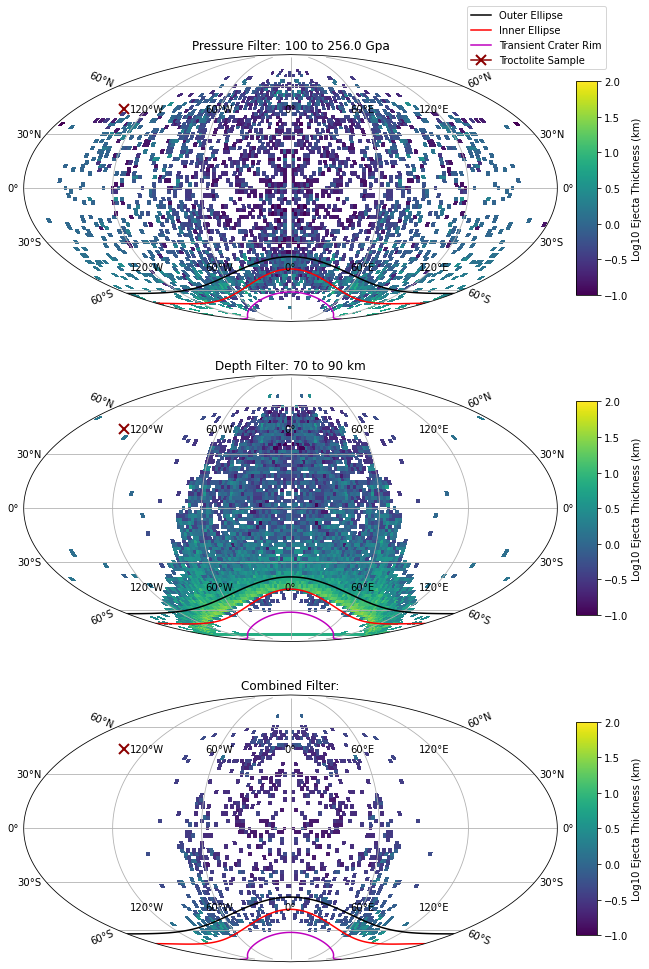

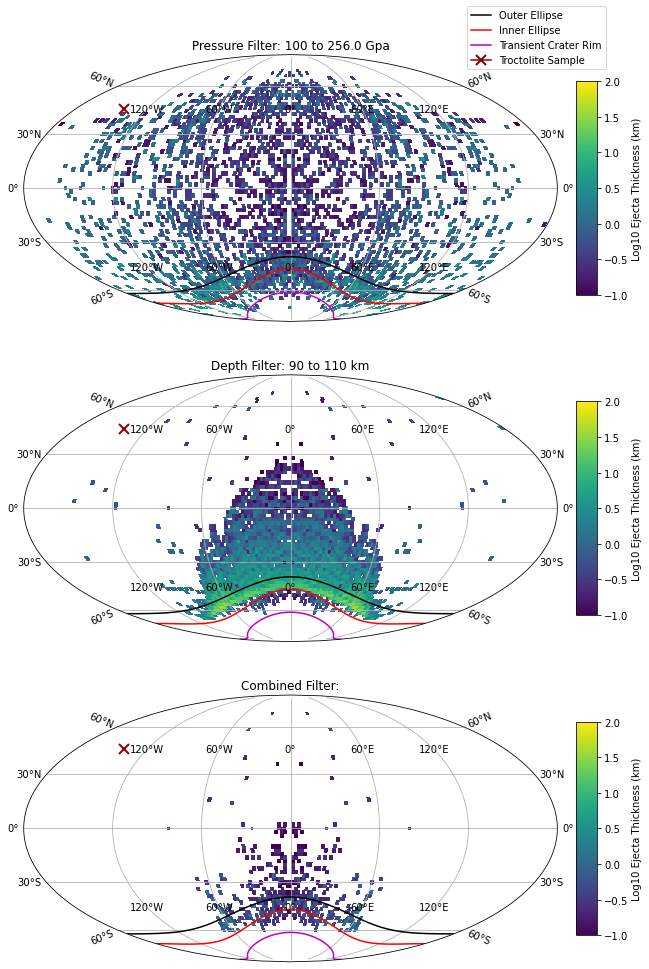

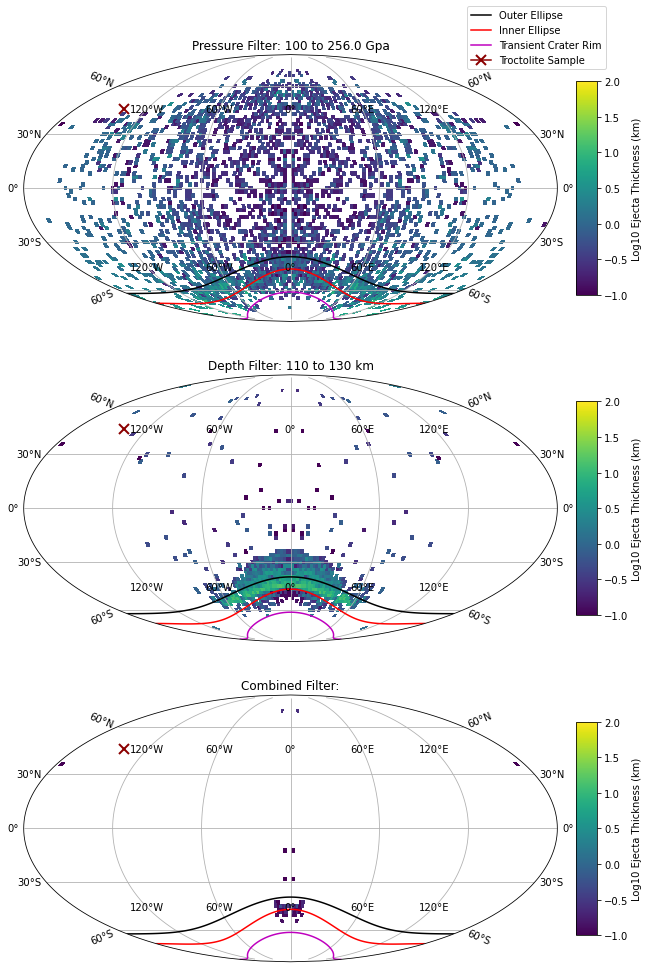

In [8]:
cartopy_plot_nested()

In [47]:
def cartopy_depth_stack():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    for min_range in np.arange(0, 50, 50):
        max_range = min_range + 50
        min_filter = depth > min_range
        max_filter = depth < max_range
        depth_filter1 = min_filter & max_filter
        for min_range2 in np.arange(50, 100, 50):
            max_range2 = min_range2 + 50
            min_filter2 = depth > min_range2
            max_filter2 = depth < max_range2
            depth_filter2 = min_filter2 & max_filter2
            for min_range3 in np.arange(100, depth.max(),50):
                max_range3 = min_range3 + 50
                min_filter3 = depth > min_range3
                max_filter3 = depth < max_range3
                depth_filter3 = min_filter3 & max_filter3
                
                layer_thickness_d1 = thickness_masking(depth_filter1)
                layer_thickness_d2 = thickness_masking(depth_filter2)
                layer_thickness_d3 = thickness_masking(depth_filter3)
                
                
                
                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_d1)
                Z2 = np.log10(layer_thickness_d2)
                Z3 = np.log10(layer_thickness_d3)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0) #inner topography ellipse
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0) #outer topography ellipse
                lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0) #transient crater
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin= -1, vmax = 2)
                cbar1 = plt.colorbar(plot1, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                ax1.set_title('Depth: 0-50 km')
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin= -1, vmax = 2)
                cbar2 = plt.colorbar(plot2, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                ax2.set_title('Depth: 50-100 km')
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis', vmin= -1, vmax = 2)
                cbar3 = plt.colorbar(plot1, label='Log10 Ejecta Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax3.set_title('Depth: 100+ km')
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label = 'Inner Ellipse')
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2, label = 'Outer Ellipse')
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2, label = 'Transient Crater Rim')
                ax2.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                
                ax1.legend(loc = 'upper right', bbox_to_anchor=(0.8, 0.7, 0.3, 0.5))
                
                
                
                plt.savefig(f'Figures/depth_stack_v15cold.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')





                
            
            





[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[ 71.9840494  105.37902454  23.65585318 ...  23.65585318 105.37902454
   71.9840494 ]
 [ 13.32042103  44.16538041  75.62850297 ...  75.62850297  44.16538041
   13.32042103]
 [ 78.90402819  25.99032278  28.37901781 ...  28.37901781  25.99032278
   78.90402819]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.78500499 ...   1.78500499   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.   

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1106471972.py:53: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_d1)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1106471972.py:54: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_d2)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_22632/1106471972.py:55: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_d3)


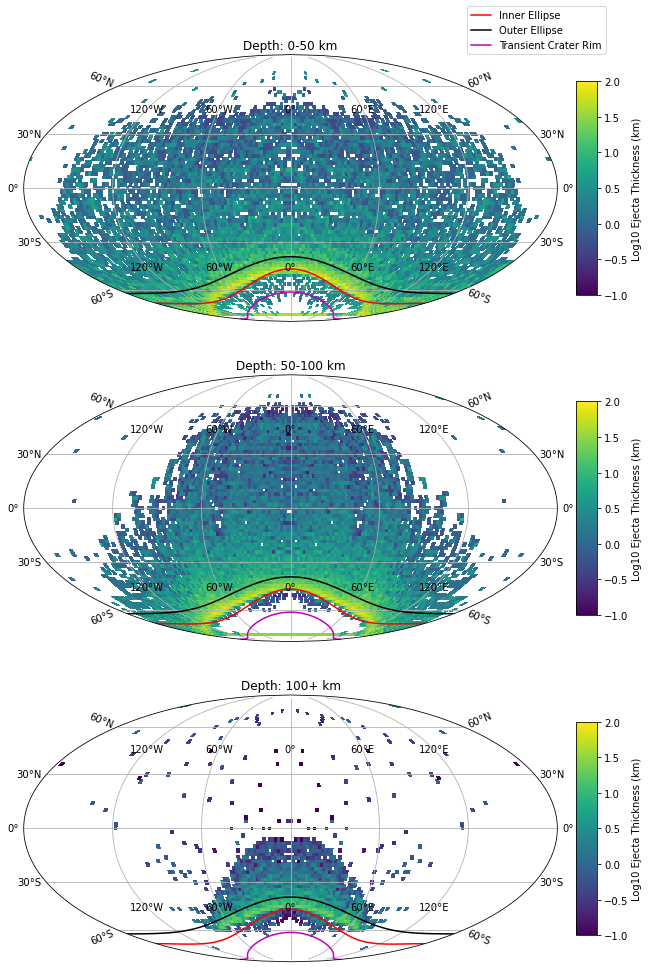

In [48]:
cartopy_depth_stack()


In [34]:
def cartopy_plot_material():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 5, 10, 25, 50, 100]
    pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]
    pressure_tuple = list(zip(pressure_mins,pressure_maxs))
    depth_min = 0
    depth_max = 100
    bin_size = 25
    for min_p, max_p in pressure_tuple:
        for min_range in np.arange(depth_min, depth_max, bin_size):
            max_range = min_range + bin_size
            min_filter = depth > min_range
            max_filter = depth < max_range

            depth_filter = min_filter & max_filter
            
            min_filt = pressure > min_p
            max_filt = pressure < max_p
            pressure_filter = min_filt & max_filt
            
            
            
    
            final_mask= pressure_filter*depth_filter
            if np.any(np.isin(final_mask, True)) == True:
                layer_thickness_pressure = thickness_masking(pressure_filter)
                layer_thickness_depth = thickness_masking(depth_filter)
                layer_thickness_combined = thickness_masking(final_mask)
            

                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_pressure)
                Z2 = np.log10(layer_thickness_depth)
                Z3 = np.log10(layer_thickness_combined)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar1 = plt.colorbar(plot1, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar2 = plt.colorbar(plot2, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar3 = plt.colorbar(plot1, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                
                plt.suptitle('Layer Thickness models: Pressure, Depth, Combined')
                plt.savefig(f'Figures/material_({min_range},{np.round(max_range)},{min_p},{max_p}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')




In [36]:
cartopy_plot_material()

54.82759400304863


(2.0, 2.5)

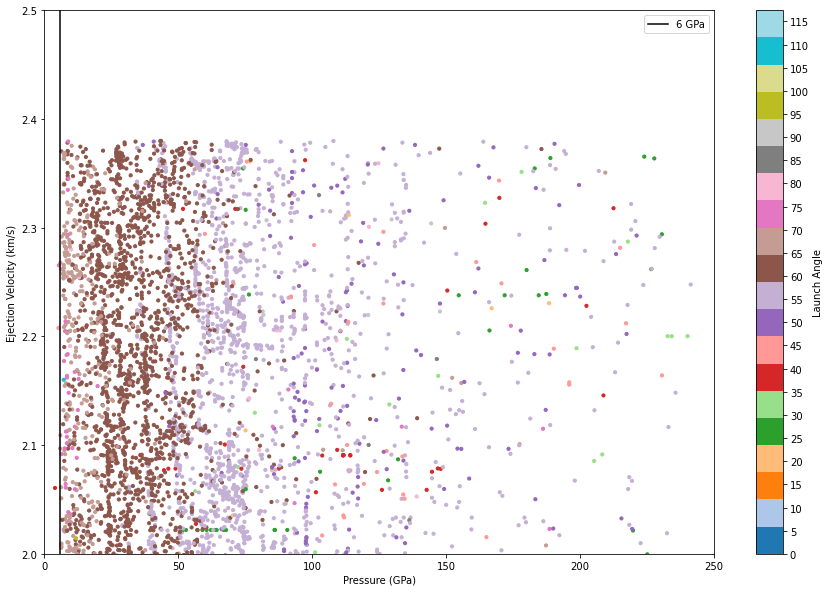

In [168]:
print(np.median(launch_angle))
plt.rcParams["figure.figsize"] = (15,10)
p = pressure
cmap = dict()
plt.scatter(p, velocity, s = 10, c = launch_angle, cmap = 'tab20')
plt.axvline(x = 6, color = 'k', label = '6 GPa')
plt.legend()
ticks = np.arange(0, launch_angle.max(), 5)
plt.clim(0, launch_angle.max())
plt.colorbar(label = 'Launch Angle', ticks=ticks)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Ejection Velocity (km/s)')

plt.xlim(0, 250, 5)
plt.ylim(2 ,2.5)
# plt.savefig('Figures/troctolite_analysis.png', dpi = 600, facecolor = 'white')